## Introduction
This post describes how to use the coco dataset for semantic segmentation. Kudos to [this blog](https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047) for giving me the necessary hints to create this.

In [1]:
#| include: false
!pip install -q git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
from pathlib import Path
import random
from typing import Any, Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

%matplotlib inline

In [ ]:
#| include: false
ROOT_PATH = Path("/kaggle/input/coco-2017-dataset/coco2017/")
BATCH_SIZE = 64
IMAGE_SIZE = (128, 128)

In [4]:
train_annotations = COCO(ROOT_PATH / "annotations/instances_train2017.json")
valid_annotations = COCO(ROOT_PATH / "annotations/instances_val2017.json")

cat_ids = train_annotations.getCatIds(supNms=["person", "vehicle"])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

Number of training images: 74152
Number of validation images: 3125


In [6]:
class ImageData(Dataset):
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: List[int], 
        cat_ids: List[int], 
        root_path: Path, 
        transform: Optional[Callable]=None
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)
        
        if self.transform is not None:
            return self.transform(img, mask)
        
        return img, mask

## Image Augmentations
When using augmentations we need to be careful to apply the same transformation to image and the mask. So for example when doing a random crop as below, we need to make it somewhat deterministic. The way to do that in torch is by getting the transformation parameters and then using `torchvision.transforms.functional` which are deterministic transformations.

In [7]:
def train_transform(
    img1: torch.LongTensor, 
    img2: torch.LongTensor
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)
    
    # Random horizontal flipping
    if random.random() > 0.5:
        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)
        
    return img1, img2

In [8]:
train_data = ImageData(train_annotations, train_img_ids, cat_ids, ROOT_PATH / "train2017", train_transform)
valid_data = ImageData(valid_annotations, valid_img_ids, cat_ids, ROOT_PATH / "val2017", train_transform)

train_dl = DataLoader(
    train_data,
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
)

valid_dl = DataLoader(
    valid_data,
    BATCH_SIZE, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
)

The following demos a single output.

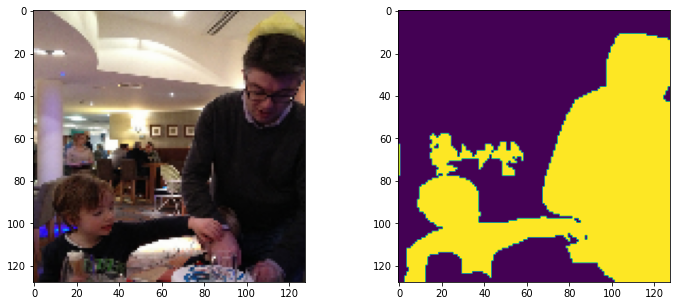

In [9]:
img, mask = train_data[22]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))
plt.subplot(122)
plt.imshow(mask.squeeze())
plt.show()

Run the following commented out section to see how long data loading takes. It takes approximately 10 minutes to run through an epoch without any modelling.

In [10]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)
# for x, y in tqdm(train_dl):
#     continue

torch.Size([64, 3, 128, 128]) torch.Size([64, 1, 128, 128])
